In [1]:
import os
import nibabel as nib
from os.path import join as pjoin
from matplotlib import pyplot as plt
from magicbox.algorithm.plot import plot_polyfit
from cxy_visual_dev.lib.predefine import proj_dir, Atlas,\
    LR_count_32k, s1200_avg_eccentricity

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/scatter')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 在早期的那几个视觉区域中，画PC1/2和eccentricity之间的散点图

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


polynomial:
  
-0.2189 x - 3.634

score: (0.6028927503274788, 4.671817153322881e-79)
polynomial:
  
0.1195 x + 6.463

score: (0.3309881202388443, 1.4168461118338246e-21)
polynomial:
  
-0.07216 x + 5.29

score: (0.09047934271342539, 0.02580379641537228)
polynomial:
  
0.1411 x + 8.064

score: (0.40963580035426195, 5.803016205023234e-26)
polynomial:
  
0.3843 x + 13.99

score: (0.5629132976314455, 2.5961678980127633e-31)
polynomial:
  
-0.1395 x + 5.309

score: (0.2146652247295677, 4.216358225640636e-05)
polynomial:
  
-0.02307 x + 2.653

score: (0.08159632306044795, 0.16144380185187454)
polynomial:
  
0.2369 x + 1.824

score: (0.32495282865266695, 1.0459364554396725e-08)
polynomial:
  
0.03832 x + 7.841

score: (0.4041047719197398, 3.8572733219901374e-07)
polynomial:
  
-0.04778 x + 6.911

score: (0.27682974398690036, 0.0006880065768553137)


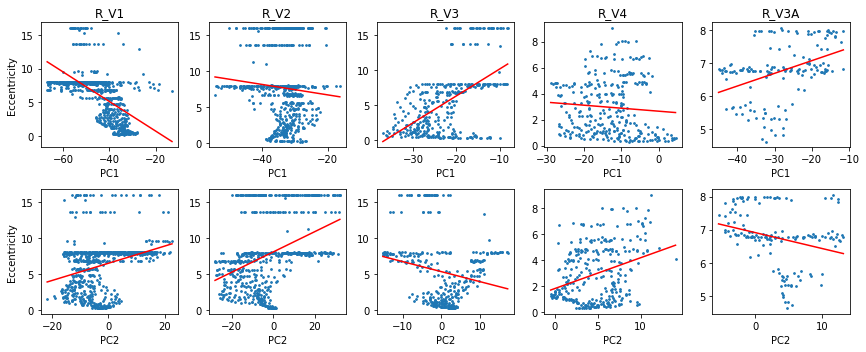

In [8]:
figsize = (12, 5)
n_pc = 2
pc_names = [f'PC{i}' for i in range(1, n_pc + 1)]
rois = ['R_V1', 'R_V2', 'R_V3', 'R_V4', 'R_V3A']
n_roi = len(rois)
out_file = pjoin(work_dir, 'PC12-corr-ECC_area.jpg')
# out_file = None

map_pcs = nib.load(pjoin(
    anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[:n_pc]
map_ecc = nib.load(s1200_avg_eccentricity).get_fdata()[0, :LR_count_32k]
atlas = Atlas('HCP-MMP')

fig, axes = plt.subplots(n_pc, n_roi, figsize=figsize)
for roi_idx, roi in enumerate(rois):
    mask = atlas.get_mask(roi)[0]
    for pc_idx, pc_name in enumerate(pc_names):
        ax = axes[pc_idx, roi_idx]
        roi_pc = map_pcs[pc_idx, mask]
        roi_ecc = map_ecc[mask]
        plot_polyfit(roi_pc, roi_ecc, 1, color='r', s=3, ax=ax)
        ax.set_xlabel(pc_name)
        if roi_idx == 0:
            ax.set_ylabel('Eccentricity')
        if pc_idx == 0:
            ax.set_title(roi)
fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)